# Analyzing Sample Locations & Geocoders

We have been given a dummy dataset with 100 sites that have been geocoded using the following geocoders: **apple, straw, grapes & orange**. In this dataset, the `v_lat` and `v_lon` columns represent the real location of the samples, that has been manually verified; whereas, the geocoders implement their own location protocols. Based on this dataset, we should:

1. Analyze which country the sites are located in.
2. Give a reasoned guess as to which geocoder is the best, how they rank between each other, and according to which criteria.

To do so, I have prepared the following notebook.

## Summary

1. Samples are all located inside the United States of America, **according to OSM and GADM**
2. Plotting them on a leaflet map confirms visually that their locations are **in the United States**
3. There is one sample over water; it should be investigated whether its location is correct
4. The geocoders can be ranked **based on their average distance to ground truth** as follows: **apple > straw >> grapes >>> orange**
5. **apple** and **straw** rank closely; however, **apple** has an smaller distance to ground truth, less outliers, and smaller quartile limits; thus **apple is the best geocoder**.


## Finding out the country location for our samples

There are a lot of different ways we could find the location of our samples. For simplicity, I will implement two: an API call to OpenStreetMap Nominatim, based on my work at my own [mapa-vxl project](https://codeberg.org/FlyingFlamingo/mapa-vxl); and a direct spatial join using data from [the GADM project](https://gadm.org/).

For the Nominatim part, it is easy: we just need to define a function that queries OSM using python's `geopy` library, and then call it:

In [1]:
import pandas as pd    # Work with CSVs

# Read the CSV file, and re-name the columns to more human-friendly names:
points_df = pd.read_csv("interview_geocode.csv", usecols=lambda column: column != "Unnamed: 0")
points_df = points_df.rename(columns={'v_lat': 'real_latitude', 'v_lon': 'real_longitude'})
points_df = points_df.rename(columns=lambda col: col.replace('_location_lat', '_lat').replace('_location_lon', '_lon'))
points_df.head()

real_longitude  real_latitude  apple_lat   apple_lon  straw_lat  \
0      -80.140036      25.970938  25.967175  -80.141671  25.969655   
1      -74.078844      40.843007  40.837265  -74.069981  40.844138   
2     -111.888251      33.269223  33.271840 -111.884106  33.261590   
3      -93.269275      44.966872  44.968429  -93.267415  44.977544   
4      -75.391091      40.100081  40.086834  -75.405068  40.085259   

    straw_lon  grapes_lat  grapes_lon  orange_lat  orange_lon  
0  -80.150446   25.935669  -80.097432   26.016421  -80.081083  
1  -74.070920   40.861805  -74.076038   40.783237  -74.019430  
2 -111.878941   33.250445 -111.931532   33.237628 -111.867397  
3  -93.268844   44.934335  -93.278985   44.970295  -93.255129  
4  -75.410947   40.059155  -75.384579   40.103281  -75.339505

In [2]:
from geopy.geocoders import Nominatim # Nominatim is OpenStreetMap's nomeclator

def get_country(geolocator, lat, lon):
    """
    Get the country for a given `latitude` and `longitude`, using OSM Nominatim.

    Args:
        geolocator (geopy.geocoders): A geocoder object that is used to query OSM
        lat (float): The latitude of the Point of Interest
        lon (float): The longitude of the Point of Interest

    Returns:
        country (str): The country if found; None if error appeared, or 
        
    """
    location = geolocator.reverse((lat, lon), language='en', timeout=10)
    if location and ('country' in location.raw['address']):
        country = location.raw['address']['country']
    else: country = None

    return country

# Define the geolocator, which we will use to query OSM
# (OSM requires us to include a custom user agent to filter the requests)
geolocator = Nominatim(user_agent="axa-geocoder-exercise")

# Apply the country locator to each row
country_df = points_df.copy()
country_df['country'] = country_df.apply(lambda row: get_country(geolocator, row['real_latitude'], row['real_longitude']), axis=1)

country_df['country'].unique().tolist()

['United States']

As we can see, all of the samples are in the US! We can verify this by plotting the samples in a map:

In [3]:
import folium         # Use leaflet.js (<3) to plot points on a map

def plot_points_on_map(df_geo, lat_col='latitude', lon_col='longitude', zoom=10,  center=None):
    """
    Plots df columns on a map using Leaflet.

    Args:
        df_geo (pd.DataFrame): The pandas dataframe with geolocation data, one point per row.
        lat_col (str): The column where we will locate the latitude of each sample
        lon_col (str): The df column where we will locate the longitudes
        zoom (int): The zoom level for the map; by default, 10
        center (tuple or list): An optional point to center the map in

    Returns:
        (folium.folium.Map): A leaflet map, with all the points plotted
    """
    if center is None: center = (df_geo[lat_col].mean(), df_geo[lon_col].mean())

    # Create map and add points to it
    m = folium.Map(location=center, zoom_start=zoom)
    for _, row in df_geo.iterrows():
        folium.Marker(
            location=[row[lat_col], row[lon_col]],
            popup=f"Lat: {row[lat_col]}, Lon: {row[lon_col]}"
        ).add_to(m)

    return m

plot_points_on_map(points_df, lat_col='real_latitude', lon_col='real_longitude', zoom = 3)

As a bonus, I will also search for the location of the samples using a local database, in a way akin to what I would be doing on my current job. The local DB has been downloaded from GADM, at [this link](https://gadm.org/download_world.html), and uses GeoPackage, an standard for spatial databases.

Be sure to download the "layers" package, which contains aggregated geometries per admin level. I normally use pre-processed versions of the GADM files, so, I'm not going to lie, it took me a bit to remember that!

In [4]:
import geopandas as gpd # Like pandas, but with geo!

# Convert the existing points df to a geo dataframe
points_gdf = gpd.GeoDataFrame(points_df, crs="EPSG:4326",
    geometry = gpd.points_from_xy(points_df['real_longitude'], points_df['real_latitude'])
)

# Read the layer 0 (country) of the GeoPackage File:
countries_gdf = gpd.read_file("gadm_410-levels.gpkg", layer = "ADM_0")

# Perform a spatial join, and return the countries for the samples:
country_df = gpd.sjoin(points_gdf, countries_gdf, how="left", predicate="within")
print(country_df['COUNTRY'].unique().tolist())

['United States', nan]


It seems like there is a sample with nan! Lets see where it is:

In [5]:
import numpy as np
weird_sample = country_df[country_df['COUNTRY'].isna()]
plot_points_on_map(weird_sample, lat_col='real_latitude', lon_col='real_longitude', zoom = 15)

The sample at fault seems to be *over the water*, which, probably, is out of the spatial geometries defined by the GADM file; but, since OpenStreetMap takes into account maritime borders, it didn't pose a problem when we used the online query.

While this is interesting - we probably identified a wrongly defined point -, it is out of the question that this sample is also under US Jurisdiction; so, we can conclude that the answer to the first question is: **all samples are located in the United States**

## Deciding which geocoder is the best

The simplest way of deciding which geocoder is the best, without being able to look at their source code, is by comparing **the distance between each geocoded sample and their real location**; the smaller this distance is, the better. We will plot these distances and see if there is any clear winner; if not, we would go on to discuss about which we can choose.

We have to take into account that the earth is a sphere when we calculate these distances; we cannot simply substract the values, since a degree of longitude does not equate the same number of meters all across the earth (because they converge at the poles), even if latitude-to-meter ratio is almost constant (be it not for the obloid shape of the earth).

Thus, the best way to proceed is to use a built-in package, such as **geopy** :

In [6]:
from geopy.distance import geodesic

def calculate_distances_geopy(geo_df, geocoder):
    """
    Calculate the distance between the points in two dataframes.

    Args:
        geo_df(pd.DataFrame): A pandas table with 'real_latitude', 'real_latitude', 
            as well as `geocoder`_lat and `geocoder`_lon columns
        geocoder (str): The geocoder that we are evaluating

    Returns:
        results (pd.Series): The result of applying geopy.distance.geodesic to the coordinates,
            making a list of the distance (in kilometers) between the samples
    """
    distance = geo_df.apply(
        lambda row: geodesic(
            (row['real_latitude'], row['real_longitude']), 
            (row[f'{geocoder}_lat'], row[f'{geocoder}_lon'])
        ).kilometers, axis=1
    )
    return distance

distance_df = pd.DataFrame()
for each_geocoder in ['apple', 'straw', 'orange', 'grapes']:
    distance_df[f'{each_geocoder}_distance'] = calculate_distances_geopy(points_df, each_geocoder)
distance_df.head()

apple_distance  straw_distance  orange_distance  grapes_distance
0        0.447936        1.052193         7.760885         5.785715
1        0.982499        0.679942         8.317751         2.100911
2        0.483059        1.212093         4.006921         4.538910
3        0.226898        1.186547         1.179073         3.696114
4        1.893210        2.361334         4.412902         4.578160

Once we have calculated the distances, we will plot a **whisker plot** with them:

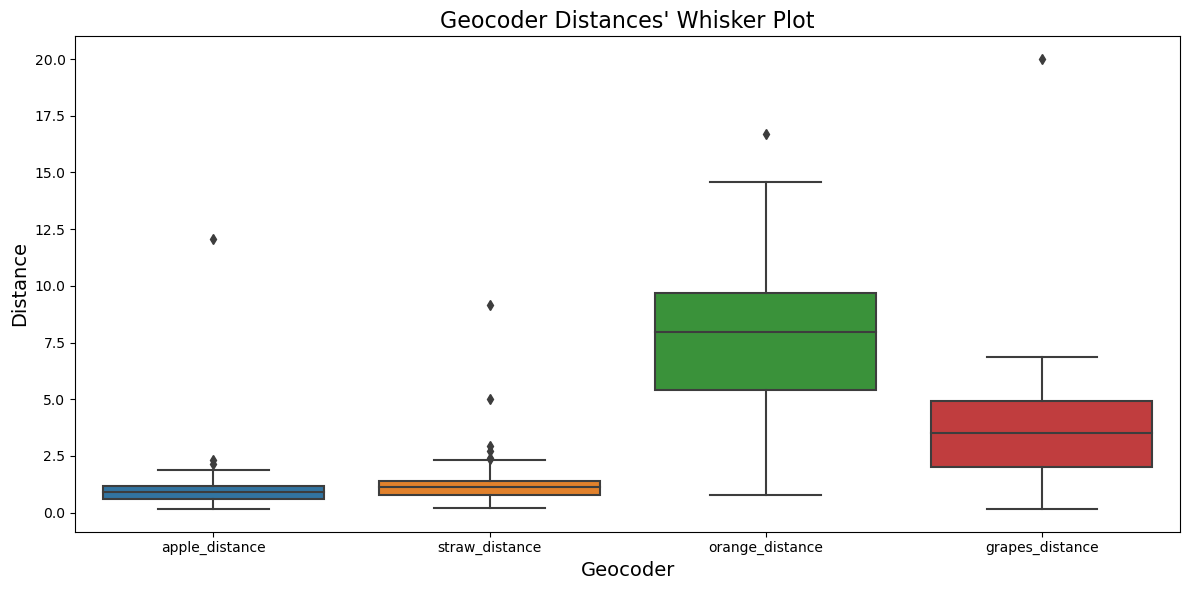

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_whiskers(data_df, columns):
    """
    Draw whisker plots from a df, using selected columns.
    
    Args:
        data_df (pandas.DataFrame): A DataFrame with the columns to draw.
        columns (list): A list of the columns to include in the plot

    Returns:
        none: It plots the desired figure
    """
    plt.figure(figsize=(12, 6))
    
    # Melt the df for Seaborn (creating a long-format table with columns Geocoder, Distance)
    melted_df = data_df[columns].melt(var_name='Geocoder', value_name='Distance')
    sns.boxplot(x='Geocoder', y='Distance', data=melted_df) # And create the plot
    
    # Add labels and plot; plt.tight_layout() is optional, to optimize space
    plt.title("Geocoder Distances' Whisker Plot", fontsize=16)
    plt.xlabel('Geocoder', fontsize=14)
    plt.ylabel('Distance', fontsize=14)
    plt.tight_layout(); plt.show()

plot_whiskers(distance_df, list(distance_df.columns))

We can already see that two geocoders, **grapes and orange**, are definetely not the best, in terms of minimizing the distance differential with the real data. However, **apple and straw** seem to be much closer, with apple having an slightly smaller distance average to the real data than straw. 

We can confirm this by looking at pandas' `df.describe()`, which will give us the numeric values for each geocoder:

In [8]:
distance_df.describe()

apple_distance  straw_distance  orange_distance  grapes_distance
count      100.000000      100.000000       100.000000       100.000000
mean         1.040814        1.246609         7.575019         3.632016
std          1.195052        1.034627         3.116735         2.379182
min          0.165324        0.219300         0.769312         0.155740
25%          0.620179        0.768911         5.427451         2.002649
50%          0.896274        1.122884         7.960971         3.494060
75%          1.188870        1.382767         9.703418         4.911116
max         12.061384        9.150569        16.696743        20.008344

We see that **apple is definetely slightly better than straw**, with a mean that could be even better were it not for a big outlier of 12 km. This is, I would argue, even a positive point; if the geocoder has *only a few points with a huge error*, it would be easier to detect them (at least, visually) than if it had *more points with an smaller error* (as is the case with straw), even if the means remain pretty simmilar.

The **distribution** of the values in both apple and straw seems to be pretty close to the average, even a bit more centered in the case of apple, which has lower distance limits for each quartile.

Taking all of this into account, I would recommend using **apple** as geocoder for our data; ranking them according to the mean of the distances to ground truth, we would get: **apple > straw >> grapes >>> orange**